In [52]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()

from sklearn.preprocessing import StandardScaler, FunctionTransformer
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, HashingVectorizer

from sklearn.cluster import KMeans, AgglomerativeClustering

from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.compose import ColumnTransformer

from sklearn.base import BaseEstimator, TransformerMixin

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

from scipy.cluster.hierarchy import dendrogram

import os
from glob import glob
import re

In [2]:
# get our text route directory
TEXT_DIR = "FedPapersCorpus"

In [3]:
# make a list of all file paths
file_paths = glob(os.path.join(TEXT_DIR, "*.txt"))

In [4]:
# peak at first 5 file paths
file_paths[:5]

['FedPapersCorpus\\dispt_fed_49.txt',
 'FedPapersCorpus\\dispt_fed_50.txt',
 'FedPapersCorpus\\dispt_fed_51.txt',
 'FedPapersCorpus\\dispt_fed_52.txt',
 'FedPapersCorpus\\dispt_fed_53.txt']

In [5]:
def get_author(file: str) -> str:
    """
    Regex to retrieve author from text file names
    
    Args:
        file: str - file name of fed paper
        
    Returns:
        text - Author information
    
    """

    return re.findall("\\\\([A-Za-z]+)_", file)[0]

In [6]:
file_paths[0]

'FedPapersCorpus\\dispt_fed_49.txt'

In [7]:
# sample a part of one paper to get a feel for the structure
with open(file_paths[0], "r") as f:
    
    lines = f.readlines()
    number_lines = len(lines)
    break_flag = True
    
    for i, line in enumerate(lines):
        if i < 20 or i > (number_lines - 20):
            print(line)
        elif break_flag:
            print()
            print("-" * 40 + "BREAK" + "-" * 40)
            print()
            break_flag = False

Federalist No. 49&nbsp;||

	  

Method of Guarding Against the Encroachments of Any One Department 

        of Government by Appealing to the People Through a Convention

        From the New York Packet.

        Tuesday, February 5, 1788.



      

Author: Alexander Hamilton or James Madison



      

To the People of the State of New York:



      

THE author of the "Notes on the State of Virginia," quoted in the last 

        paper, has subjoined to that valuable work the draught of a constitution, 

        which had been prepared in order to be laid before a convention, expected 

        to be called in 1783, by the legislature, for the establishment of a constitution 

        for that commonwealth. The plan, like every thing from the same pen, marks 

        a turn of thinking, original, comprehensive, and accurate; and is the 


----------------------------------------BREAK----------------------------------------

        to which the decision would relate. The PASSION

We will skip the the lines until we get to the part after "To the People of the State of New York:". This will be only the text we're looking for. We'll mark the text to skip if we have not come acorss the line "To the People..."

In [8]:
# read each file, get its author and then get its 
text = {"author" : [], "text" : []}

for file in file_paths:
    text["author"].append(get_author(file))

    document_text = ""
    skip = True
    with open(file, "r") as f:
        for line in f.readlines():
            if not skip:
                document_text = document_text + line

            if line.startswith("To the People of the State of New York:"):
                skip = False  
                
    text["text"].append(document_text)

In [9]:
# convert author and text to a dataframe
df = pd.DataFrame(text)

In [10]:
df.head()

,author,text
0,dispt,"\n \nTHE author of the ""Notes on the Stat..."
1,dispt,"\n \nIT MAY be contended, perhaps, that i..."
2,dispt,"\n \nTO WHAT expedient, then, shall we fi..."
3,dispt,\n \nFROM the more general inquiries purs...
4,dispt,"\n \nI SHALL here, perhaps, be reminded o..."


In [11]:
# remove multiple whitespaces and make them one
df["text"] = df["text"].apply(lambda x : ' '.join(x.split()))

In [12]:
df.head()

,author,text
0,dispt,"THE author of the ""Notes on the State of Virgi..."
1,dispt,"IT MAY be contended, perhaps, that instead of ..."
2,dispt,"TO WHAT expedient, then, shall we finally reso..."
3,dispt,FROM the more general inquiries pursued in the...
4,dispt,"I SHALL here, perhaps, be reminded of a curren..."


# Exploratory Data Analysis

Now that we have a dataframe with each author and the text, we need to convert the text into a numeric format. For text, the two main ways to do this are Word Counts or frequencies and Tfidf vectorization. We will experiment with both and see what results come. First though, some EDA on word counts.

In [23]:
# start with the basic CountVectorize, counting each word's frequency. We'll limit ourselves to only the top 100 words
cv = CountVectorizer(max_features=100)

In [24]:
# transform text to word count per document
X = cv.fit_transform(df["text"])

In [25]:
# calculate word frequencies by summing up column values and dividing each row by the sum value
X_frequencies = X / np.sum(X, axis=0)

In [26]:
# 8636 words total counted
X.shape

(85, 100)

In [27]:
X_frequencies

matrix([[0.02735562, 0.00823045, 0.01190476, ..., 0.00080064, 0.01051625,
         0.0172956 ],
        [0.00303951, 0.00685871, 0.00324675, ..., 0.00560448, 0.00478011,
         0.0086478 ],
        [0.02431611, 0.01646091, 0.00541126, ..., 0.01841473, 0.00573614,
         0.00707547],
        ...,
        [0.00303951, 0.01646091, 0.01082251, ..., 0.00320256, 0.01912046,
         0.00314465],
        [0.01823708, 0.01783265, 0.01298701, ..., 0.00880705, 0.00764818,
         0.00235849],
        [0.0212766 , 0.01920439, 0.00974026, ..., 0.0296237 , 0.0124283 ,
         0.00943396]])

In [28]:
# get the total count of each column aka each word
total_words = np.array(np.sum(X, axis=0)).flatten()

In [29]:
# swap the index number for the word in the key/value pair
id_to_word = {v:k for k,v in cv.vocabulary_.items()}

In [30]:
# get list of words and count combos in tuple form
word_counts = []
for i, ele in enumerate(total_words):
    word_counts.append((id_to_word[i], ele))

In [31]:
# sort the words from highest count to lowest count
word_counts = sorted(word_counts, key = lambda x : x[1], reverse=True)

In [32]:
# create dataframe of the words and counts
word_count_df = pd.DataFrame(word_counts, columns=["word", "count"])

In [63]:
word_count_df.head()

,word,count
0,the,17532
1,of,11606
2,to,6959
3,and,5073
4,in,4437


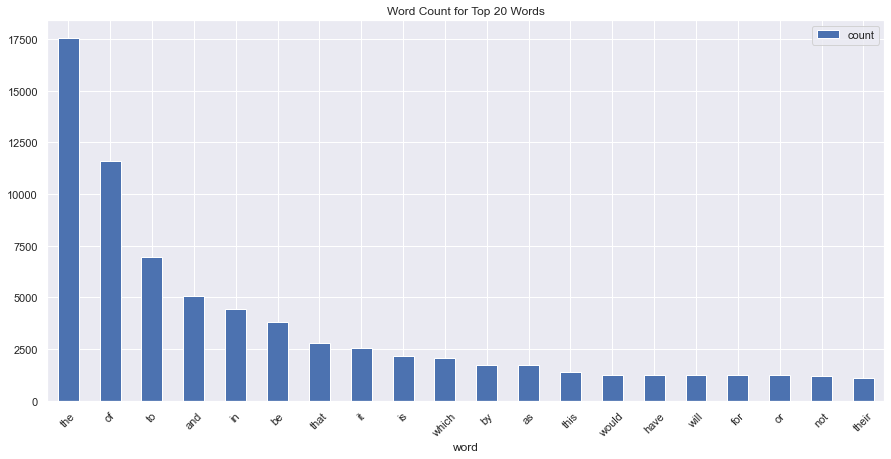

In [33]:
word_count_df.head(20).plot(kind="bar", x="word", figsize=(15,7), rot=45, title="Word Count for Top 20 Words")

Very common words happen a lot, obviously. Removing stop words can help us find the more common interesting words instead. We also refactor the above into one function.

In [34]:
def get_word_counts(text, stop_words="english"):
    """
    Takes in pandas series and converts the data to a term document matrix. 
    
    
    Args:
        text: pd.Series - pandas series as text
        stop_words: str - stop_words to use in the count vectorizer
        
    Returns:
        cv - count vectorizer object
        word_count_df - dataframe of words and their counts
    
    """
    
    cv = CountVectorizer(stop_words=stop_words, max_features=100)
    X = cv.fit_transform(text)
    total_words = np.array(np.sum(X, axis=0)).flatten()
    id_to_word = {v:k for k,v in cv.vocabulary_.items()}
    
    word_counts = []
    for i, ele in enumerate(total_words):
        word_counts.append((id_to_word[i], ele))
        
    word_counts = sorted(word_counts, key = lambda x : x[1], reverse=True)
    
    word_count_df = pd.DataFrame(word_counts, columns=["word", "count"])
    
    return cv, word_count_df

In [35]:
cv, word_count_df = get_word_counts(df["text"])

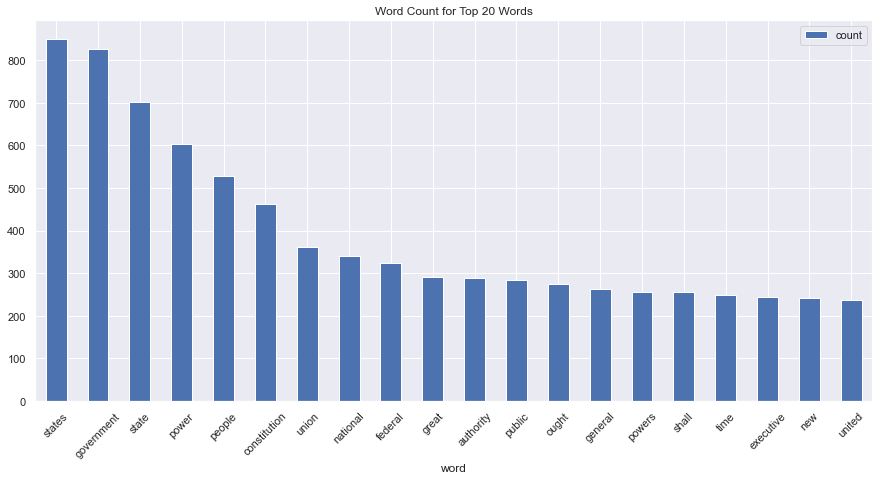

In [36]:
word_count_df.head(20).plot(kind="bar", x="word", figsize=(15,7), rot=45, title="Word Count for Top 20 Words")

That looks better. We see words like states, government, state, power, etc. This makes sense as the Federalist Papers were arguing for the adaption of the constiution. Let's expand out some the words.

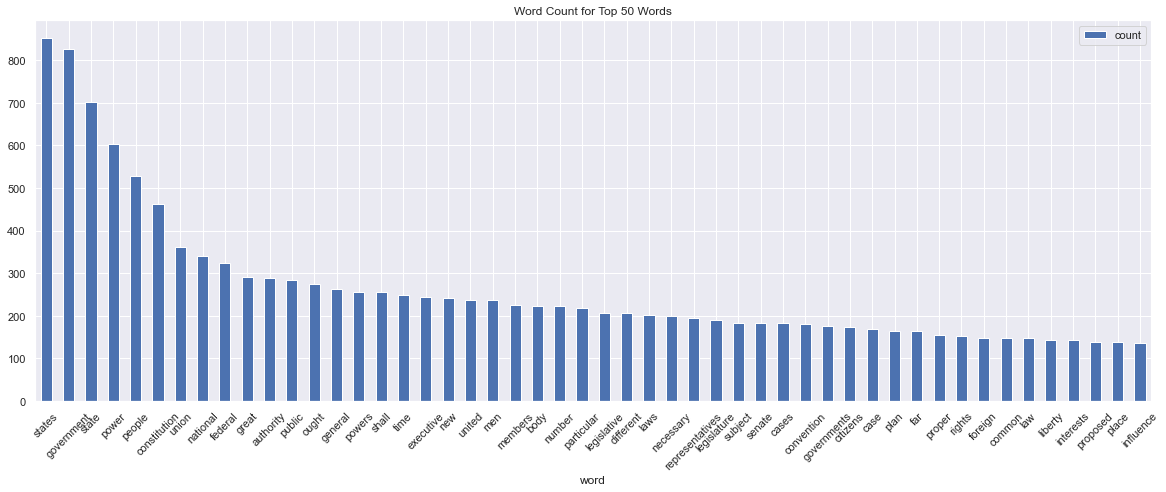

In [37]:
word_count_df.head(50).plot(kind="bar",
                            x="word",
                            figsize=(20,7),
                            rot=45,
                            title="Word Count for Top 50 Words")

Now that we have this for the aggregate, let's do the same for each author of essays. Since we are interested in Hamilton and Madison specifically, we can look only at their papers to see if the top 20 words differ.

In [43]:
df.author.unique()

array(['dispt', 'Hamilton', 'HM', 'Jay', 'Madison'], dtype=object)

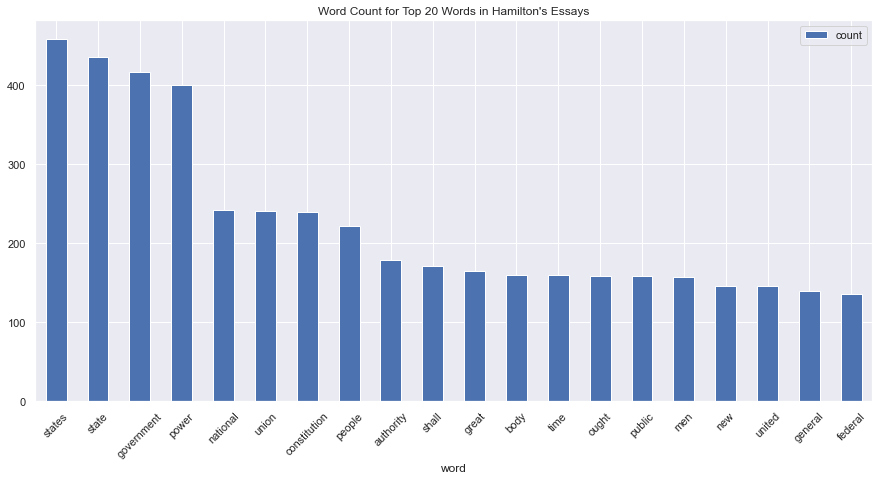

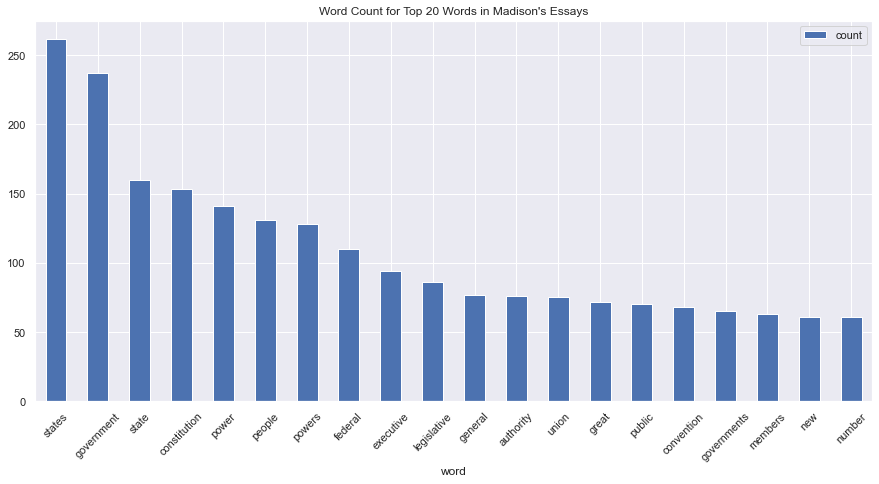

In [51]:
for author in ["Hamilton", "Madison"]:
    df_author = df.query(f"author == '{author}'")
    cv, word_count_df = get_word_counts(df_author["text"])
    word_count_df.head(20).plot(kind="bar", 
                                x="word", 
                                figsize=(15,7), 
                                rot=45, 
                                title=f"Word Count for Top 20 Words in {author}'s Essays")
    plt.show()

There is a lot of overlap between the two in terms of word usages, at least in the top 20 words. Hamilton's words occur more though, since he wrote more essays. In order to change that, we will change the word counts to frequencies for each author. Then we will reduce the dimensionality so we can visual each author and see if that gives us any insight.

In [67]:
def get_word_freqs(text, stop_words="english"):
    """
    Takes in pandas series and converts the data to a term document matrix. 
    
    
    Args:
        text: pd.Series - pandas series as text
        stop_words: str - stop_words to use in the count vectorizer
        
    Returns:
        cv - count vectorizer object
        word_count_df - dataframe of words and their counts
    
    """
    
    cv = CountVectorizer(stop_words=stop_words, max_features=100)
    X = cv.fit_transform(text).toarray()
    
    # get total words in doc
    total_words = np.sum(X, axis=1, keepdims=True)
    X_freq = X / total_words
    
    return X_freq

In [92]:
hamilton_freq = get_word_freqs(df.query("author == 'Hamilton'")["text"], stop_words="english")
madison_freq = get_word_freqs(df.query("author == 'Madison'")["text"], stop_words="english")
dispt_freq = get_word_freqs(df.query("author == 'dispt'")["text"], stop_words="english")

In [93]:
hamilton_freq.shape, madison_freq.shape, dispt_freq.shape

((51, 100), (15, 100), (11, 100))

In [94]:
combined_freq = np.vstack([hamilton_freq, madison_freq, dispt_freq])

In [96]:
pca = PCA(n_components=2)
pca_result = pca.fit_transform(combined_freq)
print(f"{pca.explained_variance_ratio_.sum() * 100 :.2f}% of variance explained by two components.")

23.39% of variance explained by two components.


In [104]:
pca_df = pd.DataFrame(pca_result, columns=["x1", "x2"])

In [105]:
authors = ["Hamilton"] * 51 + ["Madison"] * 15 + ["dispt"] * 11

In [106]:
pca_df["author"] = authors

[Text(0.5, 1.0, 'Group of Essays')]

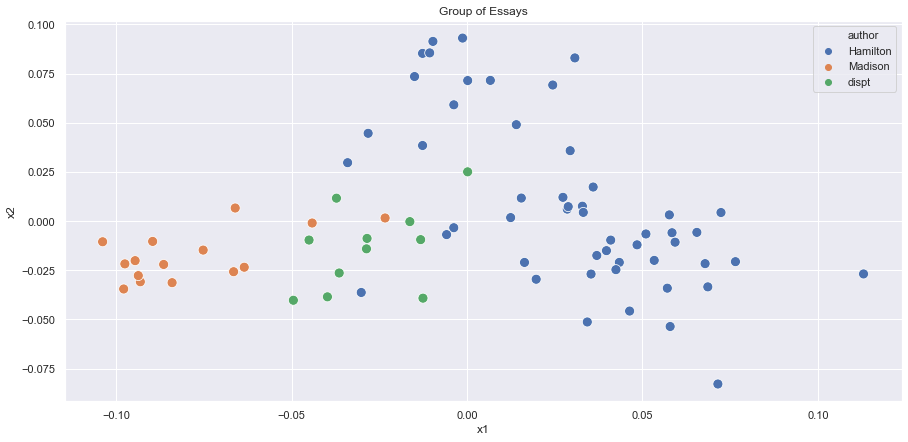

In [151]:
plt.figure(figsize=(15,7))
sns.scatterplot(data=pca_df, x="x1", y="x2", hue="author", s=100).set(title="Group of Essays")

We see from using PCA on the word frequencies per document, we see a fairly clear separation between Hamilton and Madison. The disputed essays are right in between both, making it ver interesting as to who actually wrote them. From a glance, it appears they skew a little more towards Madison, but that could just be our eyes tricking us. We can run a quick KMeans on this data and see if we can visualize some of the centroids.

In [111]:
clf = KMeans(n_clusters=2)

In [112]:
clf.fit(pca_df[["x1", "x2"]])

KMeans(n_clusters=2)

In [119]:
clf.cluster_centers_[0]

array([0.03223742, 0.00820156])

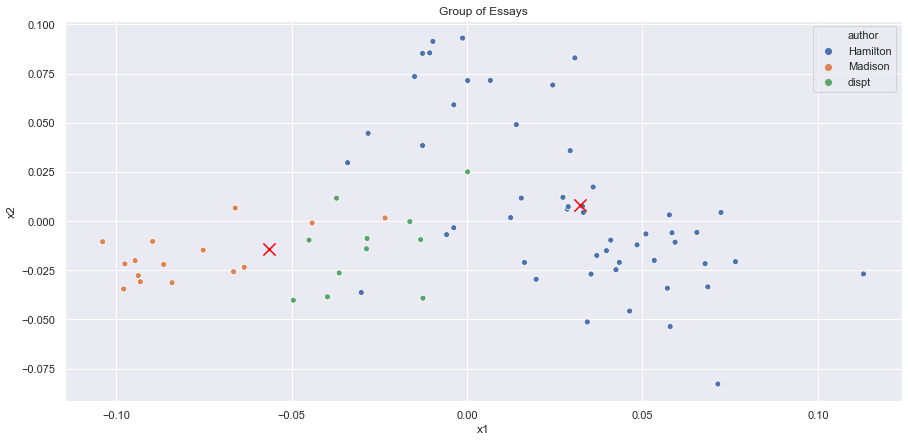

In [133]:
plt.figure(figsize=(15,7))
sns.scatterplot(data=pca_df, x="x1", y="x2", hue="author").set(title="Group of Essays")
plt.scatter(x=clf.cluster_centers_[0][0], y=clf.cluster_centers_[0][1], s=150, c="red", marker="x")
plt.scatter(x=clf.cluster_centers_[1][0], y=clf.cluster_centers_[1][1], s=150, c="red", marker="x")

Wow. This actually looks pretty good. Two clusters seems to look right from the eyeball point of view. Let's see how it labels the data through.

In [134]:
pca_df["labels"] = clf.labels_

In [144]:
pd.pivot_table(data=pca_df[["author", "labels", "x1"]], columns="labels", index="author", aggfunc="count").fillna(0)

x1      
labels       0     1
author              
Hamilton  48.0   3.0
Madison    0.0  15.0
dispt      1.0  10.0